# ML4Net - Dynamic Channel Selection through Multi-Armed Bandits

This notebook exemplifies the channel selection problem in Wi-Fi network, which is proposed to be solved using multi-armed bandits (MABs). Basic random distributions are first generated to a set of channels, which are then explored-exploited by different MAB algorithms.

---

This material is part of the course Machine Learning for Networking ("Aprenentatge automàtic per a xarxes), taught at Universitat Pompeu Fabra (UPF).

Copyright (C) 2025 Boris Bellalta & Francesc Wilhelmi, Universitat Pompeu Fabra (UPF). This work is licensed under a Creative Commons Attribution 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/.



In [36]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors

# Define global variables
N = 4               # Number of channels
seed = 123         # Seed for reproducibility
time_horizon = 200  # Total considered iterations for learning

# Initialize the random generator
rng = np.random.default_rng(seed)

## I: Creating channel reward statistics

The code below defines the random distributions behind the rewards obtained by selecting each channel.

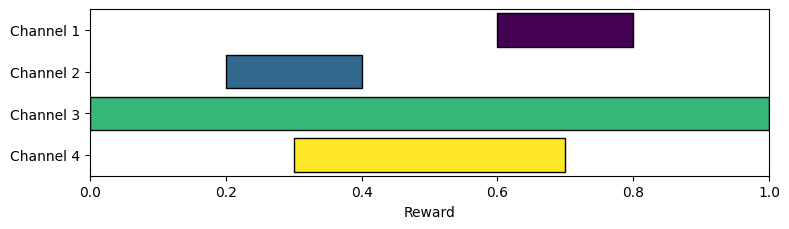

In [37]:
# Setup 1

channel_values = [[0.6, 0.8], [0.2, 0.4], [0.0, 1.0], [0.3, 0.7]]

# Setup 2
#channel_values = [[0.5, 0.8], [0.4, 0.9], [0.5, 0.8], [0.4, 0.6]]

# Function that returns a random channel occupancy
def channel_occupancy(a, b, rng):
    """
    Draws a random reward between interval a and b.

    Args:
        a (float): Lower bound of occupancy.
        b (float): Upper bound of occupancy.
        rng (numpy.random.Generator): Random number generator.

    Returns:
        float: A random occupancy value between a and b.
    """
    return a + (b - a) * rng.random()

# Function to plot the occupancy distributions
def plot_intervals(channel_values):
    """
    Plots the ranges of occupancy that can be obtained for each channel

    Args:
        channel_values (list): A 2D array with the min-max channel occupancy values.
    """
    num_rectangles = len(channel_values)
    y_positions = np.arange(num_rectangles)
    colors = plt.cm.viridis(np.linspace(0, 1, num_rectangles))

    fig, ax = plt.subplots(figsize=(8, num_rectangles * 0.6))

    for i, interval in enumerate(channel_values):
        start, end = interval
        width = end - start
        height = 0.8  # Adjust height as needed
        color = colors[i]
        rect = patches.Rectangle((start, y_positions[i] - height / 2), width, height,
                                 linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, 3.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f'Channel {i+1}' for i in range(num_rectangles)])
    ax.set_xlabel("Channel occupancy")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_intervals(channel_values)

We now make a test to validate the occupancy distibutions. For that, we sample from each distribution and plot the resulting histograms.

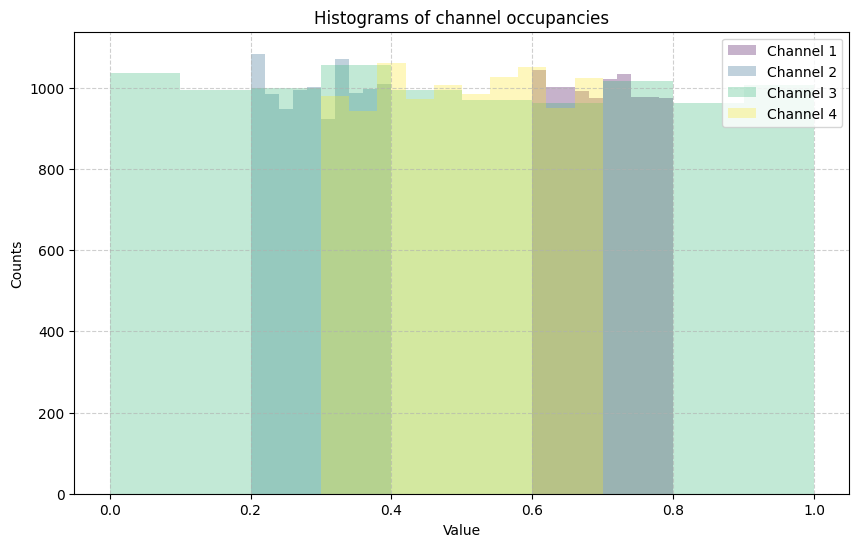

In [53]:
num_samples = 10000
samples = []

for n in range(N):
  row = []
  for i in range(num_samples):
    occupancy = channel_occupancy(channel_values[n][0], channel_values[n][1], rng)
    row.append(occupancy)
  samples.append(row)

num_rows = len(samples)
colors = plt.get_cmap('viridis', num_rows)
plt.figure(figsize=(10, 6))
for i, row in enumerate(samples):
  plt.hist(row, bins=10, alpha=0.3, label=f'Channel {i+1}', color=colors(i))
plt.title('Histograms of channel occupancies')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## II. Define MAB algorithms

Below, four different MAB algorithms are defined:
*  Brute force: Explore at the beginning and exploit later.
*  Epsilon greedy: Decide to explore or exploit based on a fixed probability.
*  Thompson sampling: Define bounds for rewards and explore optimistically.
*  UCB: Build distributions from observations and sample from them.

In [38]:
# ----------------- Brute force ------------------
def channel_selection_pure_exploration(N, seed):

    M = 1 # Times each arm is selected during exploration

    Q_BF = np.zeros(N)
    R_BF = np.zeros(time_horizon)
    ch_selected_BF = np.zeros(time_horizon, dtype=int)

    # Exploration: check all the channels

    time_to_check_all = 0

    for n in range(N):
        for m in range(M):
            ch_selected_BF[time_to_check_all] = n + 1
            rho = channel_occupancy(channel_values[n][0], channel_values[n][1], rng)
            R_BF[time_to_check_all] = 1 - rho
            Q_BF[n] = Q_BF[n] + (1 - rho)
            time_to_check_all += 1
        Q_BF[n] = Q_BF[n] / M

    # Exploitation: pick the arm with the highest reward

    n_best_BF = np.argmax(Q_BF)

    for t in range(time_to_check_all, time_horizon):
        ch_selected_BF[t] = n_best_BF + 1
        rho = channel_occupancy(channel_values[n_best_BF][0], channel_values[n_best_BF][1], rng)
        R_BF[t] = 1 - rho

    AccR_BF = np.cumsum(R_BF)

    return AccR_BF, ch_selected_BF, R_BF

# ----------------- Epsilon greedy ------------------
def channel_selection_egreedy(N, seed):

    epsilon = 0.1
    Delta = 0 / (4 * N)

    Q_EG = np.zeros(N)
    R_EG = np.zeros(time_horizon)
    ch_selected_EG = np.zeros(time_horizon, dtype=int)
    n_times_ch_selected_EG = np.zeros(N, dtype=int)

    # First Iteration

    n_sel_EG = 0

    ch_selected_EG[0] = n_sel_EG + 1
    rho_EG = channel_occupancy(channel_values[n_sel_EG][0], channel_values[n_sel_EG][1], rng)
    R_EG[0] = 1 - rho_EG
    Q_EG[n_sel_EG] = Q_EG[n_sel_EG] + (1 - rho_EG)
    n_times_ch_selected_EG[n_sel_EG] = 1

    for t in range(1, time_horizon):

        if rng.random() < epsilon:  # explore
            n_sel_EG = rng.integers(N)
        else:  # exploit
            n_sel_EG = np.argmax(Q_EG)

        ch_selected_EG[t] = n_sel_EG + 1
        n_times_ch_selected_EG[n_sel_EG] += 1
        rho_EG = channel_occupancy(channel_values[n_sel_EG][0], channel_values[n_sel_EG][0], rng)
        R_EG[t] = 1 - rho_EG
        Q_EG[n_sel_EG] = (Q_EG[n_sel_EG] * (n_times_ch_selected_EG[n_sel_EG] - 1) + (1 - rho_EG)) / n_times_ch_selected_EG[n_sel_EG]

        epsilon = max(0, epsilon - Delta)

    AccR_EG = np.cumsum(R_EG)

    return AccR_EG, ch_selected_EG, R_EG

# ----------------- UCB ------------------
def channel_selection_ucb(N, seed):

    Q_UCB = np.zeros(N)
    R_UCB = np.zeros(time_horizon)
    ch_selected_UCB = np.zeros(time_horizon, dtype=int)
    n_times_ch_selected_UCB = np.zeros(N, dtype=int)

    UCBx = N

    # First Iteration

    for i in range(N):
        n_sel_UCB = i
        ch_selected_UCB[n_sel_UCB] = n_sel_UCB + 1
        rho_UCB = channel_occupancy(channel_values[n_sel_UCB][0], channel_values[n_sel_UCB][1], rng)
        R_UCB[i] = 1 - rho_UCB
        Q_UCB[n_sel_UCB] = Q_UCB[n_sel_UCB] + (1 - rho_UCB)
        n_times_ch_selected_UCB[n_sel_UCB] = 1

    for t in range(N, time_horizon):

        Sampling_arms_UCB = np.zeros(N)
        for i in range(N):
            m = Q_UCB[i]
            if n_times_ch_selected_UCB[i] > 0:
                Sampling_arms_UCB[i] = UCBx * m + np.sqrt(2 * np.log(t + 1) / n_times_ch_selected_UCB[i])
            else:
                Sampling_arms_UCB[i] = np.inf  # To ensure unvisited arms are tried first

        n_sel_UCB = np.argmax(Sampling_arms_UCB)

        ch_selected_UCB[t] = n_sel_UCB + 1
        n_times_ch_selected_UCB[n_sel_UCB] += 1
        rho_UCB = channel_occupancy(channel_values[n_sel_UCB][0], channel_values[n_sel_UCB][1], rng)
        R_UCB[t] = 1 - rho_UCB
        Q_UCB[n_sel_UCB] = (Q_UCB[n_sel_UCB] * (n_times_ch_selected_UCB[n_sel_UCB] - 1) + (1 - rho_UCB)) / n_times_ch_selected_UCB[n_sel_UCB]

    AccR_UCB = np.cumsum(R_UCB)

    return AccR_UCB, ch_selected_UCB, R_UCB

# ----------------- Thompson Sampling ------------------
def channel_selection_ts(N, seed):

    Q_TS = np.zeros(N)
    R_TS = np.zeros(time_horizon)
    ch_selected_TS = np.zeros(time_horizon, dtype=int)
    n_times_ch_selected_TS = np.zeros(N, dtype=int)

    # First Iteration

    n_sel_TS = 0

    ch_selected_TS[0] = n_sel_TS + 1
    rho_TS = channel_occupancy(channel_values[n_sel_TS][0], channel_values[n_sel_TS][1], rng)
    R_TS[0] = 1 - rho_TS
    Q_TS[n_sel_TS] = Q_TS[n_sel_TS] + (1 - rho_TS)
    n_times_ch_selected_TS[n_sel_TS] = 1

    sigm = np.zeros(N)

    for t in range(1, time_horizon):

        Sampling_arms = np.zeros(N)
        for i in range(N):
            m = Q_TS[i]
            sigm[i] = (1 / (n_times_ch_selected_TS[i] + 1))
            Sampling_arms[i] = m + sigm[i] * rng.standard_normal()

        n_sel_TS = np.argmax(Sampling_arms)

        ch_selected_TS[t] = n_sel_TS + 1
        n_times_ch_selected_TS[n_sel_TS] += 1
        rho_TS = channel_occupancy(channel_values[n_sel_TS][0], channel_values[n_sel_TS][1], rng)
        R_TS[t] = 1 - rho_TS
        Q_TS[n_sel_TS] = (Q_TS[n_sel_TS] * (n_times_ch_selected_TS[n_sel_TS] - 1) + (1 - rho_TS)) / n_times_ch_selected_TS[n_sel_TS]

    AccR_TS = np.cumsum(R_TS)

    x = np.arange(0, 1.01, 0.01)
    y1 = np.exp(-(x - Q_TS[0])**2 / (2 * sigm[0]**2)) / (sigm[0] * np.sqrt(2 * np.pi))
    y2 = np.exp(-(x - Q_TS[1])**2 / (2 * sigm[1]**2)) / (sigm[1] * np.sqrt(2 * np.pi))
    y3 = np.exp(-(x - Q_TS[2])**2 / (2 * sigm[2]**2)) / (sigm[2] * np.sqrt(2 * np.pi))
    y4 = np.exp(-(x - Q_TS[3])**2 / (2 * sigm[3]**2)) / (sigm[3] * np.sqrt(2 * np.pi))

    plt.figure()
    plt.plot(x, y1 / np.max(y1), label='Channel 1')
    plt.plot(x, y2 / np.max(y2), label='Channel 2')
    plt.plot(x, y3 / np.max(y3), label='Channel 3')
    plt.plot(x, y4 / np.max(y4), label='Channel 4')
    plt.xlabel('values')
    plt.ylabel('pdf')
    plt.legend()
    plt.grid(True)
    plt.title('Probability Density Functions (Thompson Sampling)')
    plt.show()

    return AccR_TS, ch_selected_TS, R_TS

## III. Run the MAB algorithms



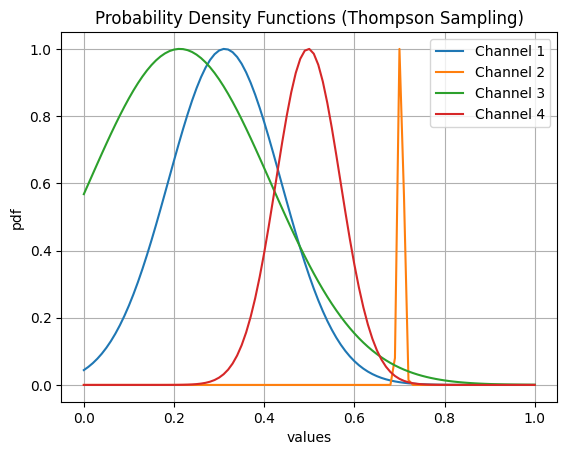

Which is the best one? Brute Force (M=1) | EG | TS | UCB
[np.float64(140.4647820382958), np.float64(186.8445252099328), np.float64(133.26147983147948), np.float64(135.61427015808127)]


In [39]:
# -------------------------------

AccR_BF, ch_selected_BF, R_BF = channel_selection_pure_exploration(N, seed)
AccR_EG, ch_selected_EG, R_EG = channel_selection_egreedy(N, seed)
AccR_TS, ch_selected_TS, R_TS = channel_selection_ts(N, seed)
AccR_UCB, ch_selected_UCB, R_UCB = channel_selection_ucb(N, seed)

print('Which is the best one? Brute Force (M=1) | EG | TS | UCB')
print([AccR_BF[-1], AccR_EG[-1], AccR_TS[-1], AccR_UCB[-1]])

## IV. Plot the results

### IV.A Plot the channels selected in each iteration by each algorithm

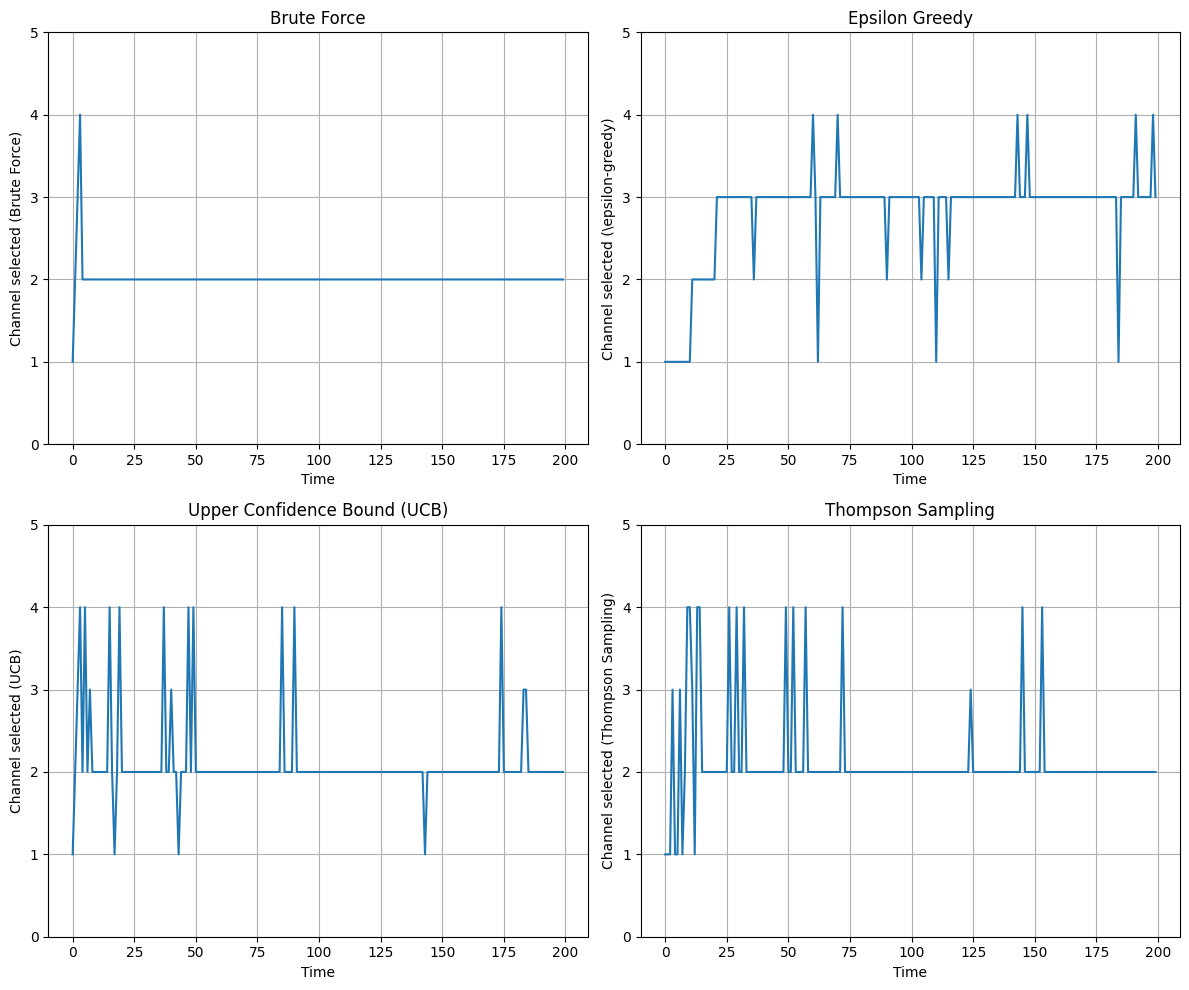

In [40]:
# Create a figure and a grid of 2x2 subplots
fig = plt.figure(figsize=(12, 10))  # Adjust figure size for better readability

# Subplot 1: Brute Force
plt.subplot(2, 2, 1)
plt.plot(ch_selected_BF)
plt.ylabel('Channel selected (Brute Force)')
plt.ylim([0, N + 1])
plt.xlabel('Time')
plt.title('Brute Force')
plt.grid(True)
# Note: You had ax2.legend() in your original code, but ax2 was never defined in those individual plots.
# If you intended to have a second y-axis with a legend, you'd need to set that up within this subplot.

# Subplot 2: Epsilon Greedy
plt.subplot(2, 2, 2)
plt.plot(ch_selected_EG)
plt.ylabel('Channel selected (\epsilon-greedy)')
plt.ylim([0, N + 1])
plt.xlabel('Time')
plt.title('Epsilon Greedy')
plt.grid(True)
# Same note about ax2.legend() applies here.

# Subplot 3: Upper Confidence Bound (UCB)
plt.subplot(2, 2, 3)
plt.plot(ch_selected_UCB)
plt.ylabel('Channel selected (UCB)')
plt.ylim([0, N + 1])
plt.xlabel('Time')
plt.title('Upper Confidence Bound (UCB)')
plt.grid(True)
# Same note about ax2.legend() applies here.

# Subplot 4: Thompson Sampling
plt.subplot(2, 2, 4)
plt.plot(ch_selected_TS)
plt.ylabel('Channel selected (Thompson Sampling)')
plt.ylim([0, N + 1])
plt.xlabel('Time')
plt.title('Thompson Sampling')
plt.grid(True)
# Same note about ax2.legend() applies here.

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### IV.B Plot the instantaneous and cumulative rewards experienced by each algorithm

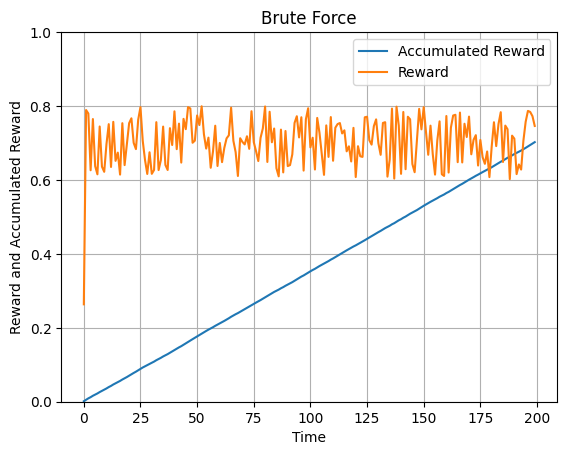

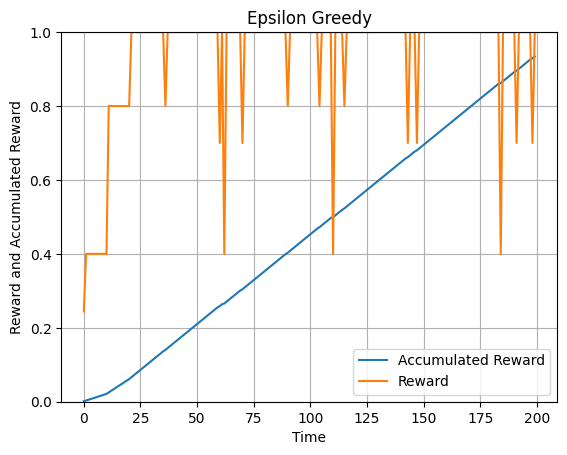

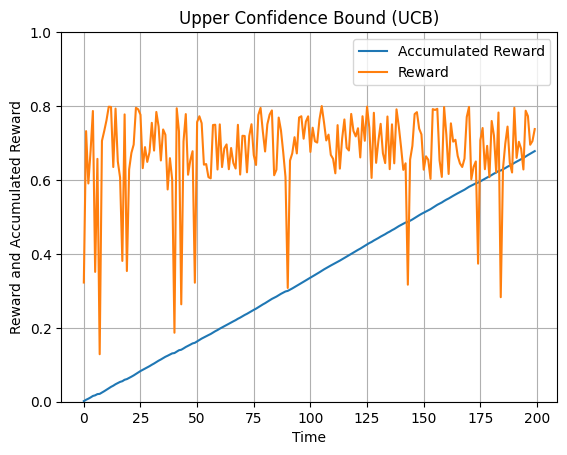

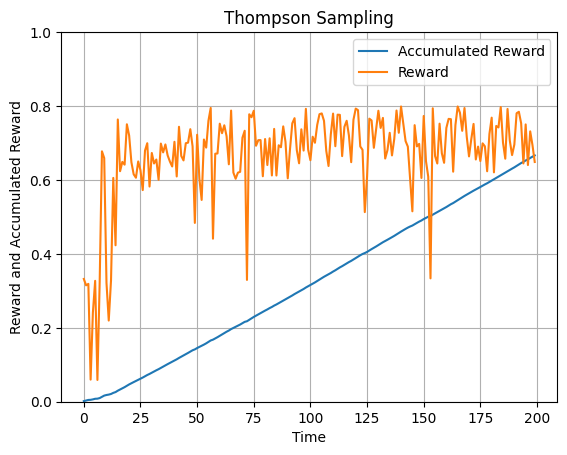

In [41]:
# Plot the results

fig, ax1 = plt.subplots()
ax1.set_ylim([0, N + 1])
ax1.set_ylim([0, 1])
ax1.plot(AccR_BF / time_horizon, label='Accumulated Reward')
ax1.plot(R_BF, label='Reward')
ax1.set_ylabel('Reward and Accumulated Reward')
ax1.set_xlabel('Time')
plt.title('Brute Force')
ax1.legend()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots()
ax1.set_ylim([0, N + 1])
ax1.set_ylim([0, 1])
ax1.plot(AccR_EG / time_horizon, label='Accumulated Reward')
ax1.plot(R_EG, label='Reward')
ax1.set_ylabel('Reward and Accumulated Reward')
ax1.set_xlabel('Time')
plt.title('Epsilon Greedy')
ax1.legend()
plt.grid(True)
plt.show()


fig, ax1 = plt.subplots()
ax1.set_ylim([0, N + 1])
ax1.set_ylim([0, 1])
ax1.plot(AccR_UCB / time_horizon, label='Accumulated Reward')
ax1.plot(R_UCB, label='Reward')
ax1.set_ylabel('Reward and Accumulated Reward')
ax1.set_xlabel('Time')
plt.title('Upper Confidence Bound (UCB)')
ax1.legend()
plt.grid(True)
plt.show()


fig, ax1 = plt.subplots()
ax1.set_ylim([0, N + 1])
ax1.set_ylim([0, 1])
ax1.plot(AccR_TS / time_horizon, label='Accumulated Reward')
ax1.plot(R_TS, label='Reward')
ax1.set_ylabel('Reward and Accumulated Reward')
ax1.set_xlabel('Time')
plt.title('Thompson Sampling')
ax1.legend()
plt.grid(True)
plt.show()